In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.gridspec as gridspec
import xarray as xr
from matplotlib.pyplot import cm 

# %matplotlib notebook

In [2]:
test_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output")
pca_dir = test_dir / "PCA_analysis_4"

select_set = 'set1_0'      # 'set1' 'set2'
select_type = 'single'     # 'grid' 'single'
labels = ['60%', '70%', '80%', '90%', '95%', '99%' ]

def get_pca_files(search_dir, dataset, datatype, fmt = '*.csv'): 
    
    files = [file for file in search_dir.glob(fmt) if not 'class' in file.stem and datatype in file.stem and dataset in file.stem] 
    
    pca_set = [file for file in files if not 'noPCA' in file.stem]
    pca_bench = [file for file in files if 'noPCA' in file.stem ]
     
    return pca_set, pca_bench 

In [3]:
## TO DO
## - add std bars to bar plots 
## - check confusion matrix value plots 


In [4]:
save_dir  = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\meetings\2021_06_28_GL\new_media")

In [13]:
fn_bench = [file for file in pca_dir.glob("*.csv") if 'range' in file.stem][0]

df_bench = pd.read_csv(fn_bench)
# df_bench['hit_rate'] = df_bench['hit_ratio']

stat_cols = ['accuracy', 'precision', 'recall', 'f1', 'balanced_acc', 'hit_rate',
            'TP', 'TN', 'FP', 'FN', 'n', 'N']

df_bench.groupby(by='model')[stat_cols].mean()

,accuracy,precision,recall,f1,balanced_acc,hit_rate,TP,TN,FP,FN,n,N
model,,,,,,,,,,,,
CC,0.986796,0.465209,0.483471,0.237082,0.738271,0.483471,234,38552,269,250,484,39305
KGE,0.979519,0.180915,0.188017,0.092198,0.588702,0.188017,91,38409,412,393,484,39305
NSE,0.978654,0.147117,0.152893,0.074974,0.570921,0.152893,74,38392,429,410,484,39305
RMSE,0.978654,0.147117,0.152893,0.074974,0.570921,0.152893,74,38392,429,410,484,39305


In [7]:

def display_single_algorithm_performance(df_performance, grouper='model', 
                                 stat_cols = ['accuracy', 'precision', 'recall', 'f1', 'balanced_acc'],
                                 performance_labels = [], out_dir=None, fn_stem=None, plot_yerr = False):
    
    sum_performance = df_performance.groupby(by=grouper)[stat_cols].mean()
    

    var_performance = df_performance.groupby(by=grouper)[stat_cols].std()

    
    model_types = sum_performance.index.values 
    
    x_plot = np.arange(0, len(stat_cols), 1.)
    
    for ix_type in model_types:
        
        if plot_yerr:
            y_err = var_performance.loc[ix_type].values
        else:
            y_err = None
        
        plt.figure(figsize=(4,3))
        plt.bar( x_plot, sum_performance.loc[ix_type].values, 
               yerr = y_err)
        
        plt.title(ix_type, size=16)
        
        if len(performance_labels) != len(x_plot):
            plt.xticks(x_plot, stat_cols, rotation=30, size=14)
        else:
            plt.xticks(x_plot, performance_labels, rotation=30, size=14)
        plt.ylim(0,1.1)
        plt.yticks(size=14)
        plt.grid()
        plt.tight_layout() 
        
        if fn_stem is not None:
            fn = f'{fn_stem}_{ix_type}.png'
#             fn = f'{fn_stem}_{ix_type}.pdf'
            if out_dir is not None:
                fn = out_dir / fn
            plt.savefig(fn)

    return 

In [ ]:
# pf_labels = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'Balanced Acc.']
# # display_single_algorithm_performance(df_bench, performance_labels=pf_labels),
# #                                            out_dir = save_dir, fn_stem = 'benchmark_grid')


# pca_set, pca_bench = get_pca_files(pca_dir, 'set2', 'grid', fmt = '*.csv')
# # df_pca_bench = pd.read_csv(pca_bench[0])

# list_files = pca_bench + pca_set 
# list_models = ['LR-2', 'RF-2', 'SVM-2', 'k-nn-2']
# target_names = [ model_str.split('-')[0] for model_str in list_models ]

# for ix_cat, fn in enumerate(list_files):
    
#     out_fn = f'set2_grid_{ fn.stem.split("_")[3] }'
    
#     df = pd.read_csv(fn)    
#     df = df[ df['model'].isin(list_models) ].copy()
    
#     for i, model_type in enumerate(list_models):
#         df.loc[ df['model'] == model_type, 'rename_model' ] = target_names[i] 
    
#     sns.barplot(x="model", y="accuracy", data=df)
    
    
#     display_single_algorithm_performance(df, grouper='rename_model',
#                                         performance_labels = pf_labels,
#                                         out_dir = save_dir, fn_stem = out_fn)
    


In [8]:
## base 

def display_performance(benchmark_0, benchmark_1, list_performance_fn, grouper = 'model',
                        stat_cols=['accuracy', 'precision', 'recall', 'f1', 'balanced_acc'], performance_labels = [],
                       out_dir = None, fn_stem = None):
    
    ## benchmark
    sum_bench0 = benchmark_0.groupby(by=grouper)[stat_cols].mean()
    bench0_algs = sum_bench0.index.values

    ## benkchmark performance model
    sum_bench1 = benchmark_1.groupby(by=grouper)[stat_cols].mean() 
    var_bench_min = benchmark_1.groupby(by=grouper)[stat_cols].min()
    var_bench_max = benchmark_1.groupby(by=grouper)[stat_cols].max()
    eval_algs = sum_bench1.index.values 
  
    ## load list of df_performance 
    list_performance_df = []
    list_var_min = [] 
    list_var_max = []
    
    for fn in list_performance_fn:

        _df = pd.read_csv(fn)
        
        sum_df = _df.groupby(by=grouper)[stat_cols].mean()
        list_performance_df.append(sum_df)

        
        var_min = _df.groupby(by=grouper)[stat_cols].min()
        var_max = _df.groupby(by=grouper)[stat_cols].max()
        list_var_min.append(var_min)
        list_var_max.append(var_max)



    for col in stat_cols:

        fig = plt.figure(figsize=(14,4))
        x_plot = 0.

        x_tick_loc = []
        x_tick_label = []

        plt.title(col, size=16) # .capitalize()
        
        if col in ['TP', 'FP', 'TN', 'FN']:
            bench_factor = 0.2 
        else:
            bench_factor = 1.

        for alg in bench0_algs:
            plt.bar(x_plot, sum_bench0.loc[alg,col]*bench_factor, width=3, color='grey', label='Benchmark')

            x_tick_loc.append(x_plot)
            x_tick_label.append(alg)

            x_plot += 3.5

        x_plot += 4

        select_cmap = cm.cubehelix(np.linspace(0,0.8, len(list_performance_df)))
        
        var_labels = ['60% var explained', '70% var explained', '80% var explained',
                     '90% var explained', '95% var explained', '99% var explained'] 

        for alg in eval_algs:
                        
            if '2' in alg:
                
                alg_name = alg.split('-')[0]
                
                if 'k-nn' in alg:
                    alg_name = 'k-nn'
                
                
                err_min = sum_bench1.loc[alg,col] - var_bench_min.loc[alg,col]  
                err_max = var_bench_max.loc[alg,col] -  sum_bench1.loc[alg,col] 
                y_err = np.array([ [err_min], [err_max]])

                plt.bar(x_plot, sum_bench1.loc[alg,col], width=3, color='dimgrey',
                       yerr = y_err, label='No PCA')

    #             if len(performance_labels) > 0:
    #                 plt.text(x_plot-0.1, 0.1, performance_labels[0], rotation = 90, color = 'black', size=8)

                x_tick_loc.append( (x_plot+ 1.75*len(list_performance_df)) )
                x_tick_label.append(alg_name)
                x_plot += 3.5 

                for i, df_alg in enumerate(list_performance_df):
                    
                    err_min = df_alg.loc[alg,col] - list_var_min[i].loc[alg,col]
                    err_max = list_var_max[i].loc[alg,col] - df_alg.loc[alg,col]
                    y_err = np.array([[err_min], [err_max]])
                    
                    plt.bar(x_plot, df_alg.loc[alg,col], width = 3, color=select_cmap[i], # color='cadetblue',
                            yerr= y_err, 
                            label = var_labels[i])
                        
#                     if len(performance_labels) > 0:
#                         plt.text(x_plot-1, 0.1, performance_labels[i], color = 'black', size=8, rotation=90)

                    x_plot += 3.5

                x_plot += 4 
        
        if col in ['TP', 'FP', 'TN', 'FN']:
            plt.ylim(0,100)
            plt.yticks(np.arange(0,101, 10), np.arange(0,101, 10))
        else:
            plt.ylim(0,1.1)
        
        plt.xticks(x_tick_loc, x_tick_label, size = 14, rotation = 50)
        plt.grid()
        
        
#         handles, labels = plt.gca().get_legend_handles_labels() 
#         by_label = dict(zip(labels, handles))
#         plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1,0.95), fontsize=14)
    
        plt.xlim(-2, x_plot-1)
        plt.tight_layout()

        if out_dir != None:
            if fn_stem == None:
                fn = out_dir / 'plot_{}.png'.format(col)
            else:
                fn = out_dir / 'plot_{}_{}.png'.format(fn_stem, col)
            plt.savefig(fn)

    return 

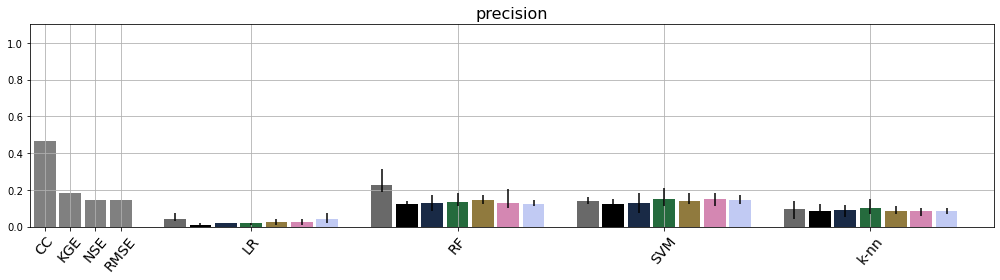

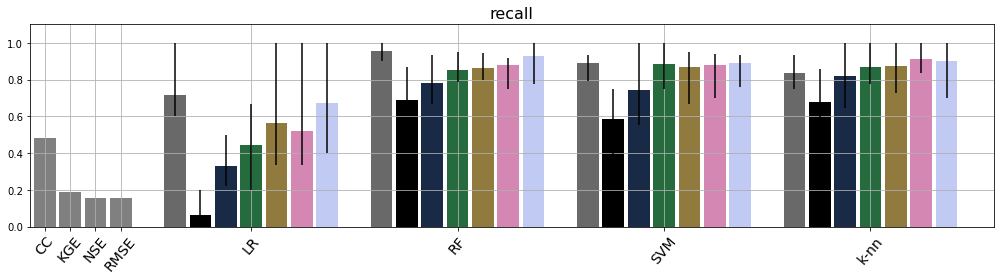

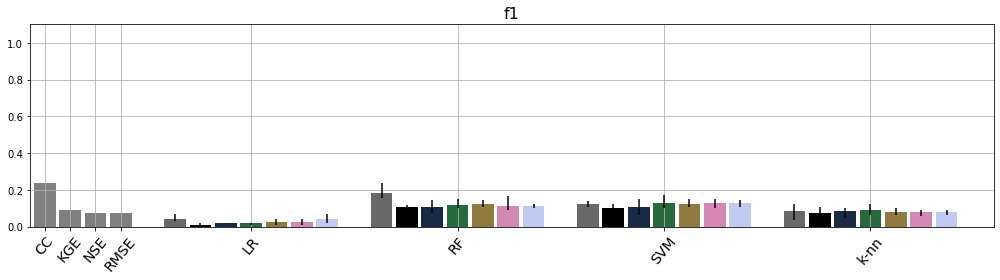

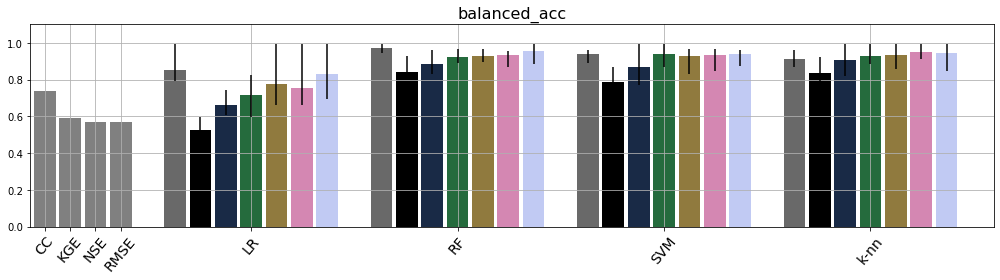

In [16]:
### set 1 - single pixel 
labels = ['60%', '70%', '80%', '90%', '95%', '99%' ]
display_cols = [
#                 'accuracy', 
                'precision', 'recall', 'f1', 'balanced_acc', 
#                 'hit_rate',
#                 'TP', 'FP', #'TN', 'FN', 
#                 'n', 'N']
                ]

fig_dir = test_dir 

select_set = 'set1_6'
select_format = 'pf_single'



pca_set, pca_bench = get_pca_files(pca_dir, select_set, select_format, fmt = '*.csv')

df_pca_bench = pd.read_csv(pca_bench[0])

display_performance( df_bench, df_pca_bench, pca_set, performance_labels = labels,
                     stat_cols = display_cols, 
#                      out_dir = save_dir, fn_stem= f'{select_set}_{select_format}'
                   )


# df_pca_bench.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

# ix=0
# print(pca_set[ix].stem)
# df = pd.read_csv(pca_set[ix])
# df.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

In [ ]:
pca_dir2 =  test_dir / "PCA_analysis_3" 

select_set = 'set1_0'
select_format = 'pf_single'

pca_set, pca_bench = get_pca_files(pca_dir2, select_set, select_format, fmt = '*.csv')

df_pca_bench = pd.read_csv(pca_bench[0])

# display_performance( df_bench, df_pca_bench, pca_set, performance_labels = labels,
#                      stat_cols = display_cols, 
#                      out_dir = save_dir, fn_stem= f'{select_set}_{select_format}'
#                    )
# 
# df_pca_bench.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

ix=0
print(pca_set[ix])
df = pd.read_csv(pca_set[ix])
df.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

In [ ]:
# df_pca_bench.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

# ix=0
# print(pca_set[ix].stem)
# df = pd.read_csv(pca_set[ix])
# df.groupby(by='model')[stat_cols].mean().loc[['RF-2', 'SVM-2', 'k-nn-2', 'LR-2' ]]

In [17]:
def plot_pareto(benchmark_0, benchmark_1, list_performance_fn, grouper = 'model',
                performance_labels = [],
                out_dir = None, fn_stem = None):
    
    pareto_cols = ['precision', 'recall']
    
    ## benchmark
    sum_bench0 = benchmark_0.groupby(by=grouper)[pareto_cols].mean()
    bench0_algs = sum_bench0.index.values

    ## benkchmark performance model
    sum_bench1 = benchmark_1.groupby(by=grouper)[pareto_cols].mean() 
    eval_algs = [ alg for alg in sum_bench1.index.values if '2' in alg]
  
    ## load list of df_performance 
    list_performance_df = []
    for fn in list_performance_fn:

            _df = pd.read_csv(fn)

            sum_df = _df.groupby(by=grouper)[pareto_cols].mean()
            list_performance_df.append(sum_df)

    
    select_cmap = cm.gnuplot(np.linspace(0., 0.9, len(eval_algs) )) 

#     select_cmap = []
    
    show_markers = ["v", "^", "*", "s", "d", "p", ".", 'x']
    
    fig = plt.figure(figsize=(6,5)) 
    
    # plot bench 
    plt.plot( sum_bench0[pareto_cols[0]].values, sum_bench0[pareto_cols[1]].values,
            linestyle='none', marker = 'o', markersize=6, 
            color = 'royalblue',
             label='benchmark'
            )  

    for i, alg in enumerate(eval_algs):  
        
        if '2' in alg:
        
            plt.plot(sum_bench1.loc[alg, pareto_cols[0]], sum_bench1.loc[alg, pareto_cols[1]],
                linestyle='none', 
                marker = 'x', 
                markersize=6, 
                color = select_cmap[i], 
                label= f'{alg} - no PCA'
                )       

            for j, df in enumerate(list_performance_df):
                
                if len(performance_labels) > 0:
                    set_label = f'{alg} - {performance_labels[j]}'
                else:
                    if j == 0:
                            set_label = alg
                    else:
                        set_label = None
                    
                plt.plot( 
                    df.loc[alg, pareto_cols[0]], df.loc[alg, pareto_cols[1]],
                    linestyle='none', marker=show_markers[j], markersize=6,
                    color = select_cmap[i],
                    label= set_label 
                )
        
    
    plt.xlabel(pareto_cols[0].capitalize(), size=16)
    plt.ylabel(pareto_cols[1].capitalize(), size=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.grid()
    lgd = plt.legend(bbox_to_anchor=(1.1,1), ncol=2, fontsize=16 )
    
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
#     plt.tight_layout()

    if out_dir != None:
        if fn_stem == None:
            fn = out_dir / 'plot_pareto.png'.format(col)
        else:
            fn = out_dir / 'plot_pareto_{}.png'.format(fn_stem)

        plt.savefig(fn, bbox_extra_artists=(lgd,), bbox_inches='tight')

    return 

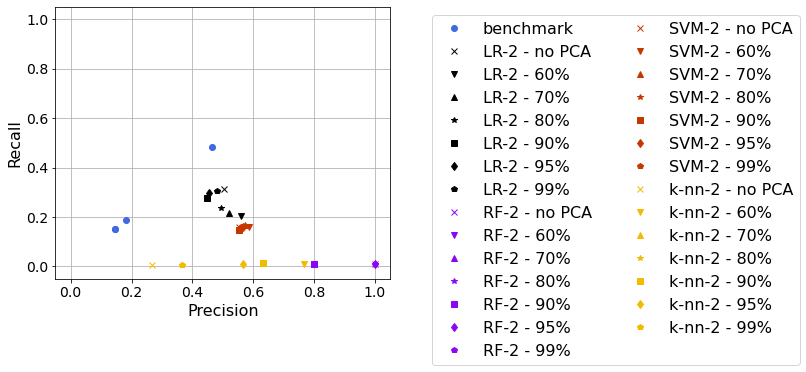

In [18]:

select_set = 'set1_6'
select_format = 'pf_grid'

save_file = f'{select_set}_{select_format}'

pca_set, pca_bench = get_pca_files(pca_dir, select_set, select_format, fmt = '*.csv')

df_pca_bench = pd.read_csv(pca_bench[0])


plot_pareto(df_bench, df_pca_bench, pca_set,
            performance_labels = labels,
#             out_dir = save_dir, fn_stem = save_file
           )


In [ ]:
## load classification results - analyse p0 and p1 for TP and FP

class_files = [file for file in pca_dir.glob('*.csv') if 'cl' in file.stem]
set1_class = [file for file in class_files if 'set1_0' in file.stem]
set2_class = [file for file in class_files if 'set2' in file.stem]



In [ ]:
for file in set1_class:
    print(file)

In [ ]:
def plot_confusion(df, range_col, target_col, model, title, save_dir = None,
                  label_1 = 'TP', label_2 = 'FP', id_col = 'tag'):
    
    ## TP 
    ## if prediction in one of range_col 
    if 'TP' in label_1:
        
        ix_TP = []
        
        for ix in df[id_col].unique(): 
            nTP = df[ (df[id_col] ==  ix) & (df[range_col] == 1) ]
            
            # predict
#             if df[ (df[id_col] ==ix) & (df[hat_col]==1.) ].index in nTP.index.values:
                
            
        
        
        ## TP 
        plot_1 = df[ (df[range_col] ==1) & (df[hat_col]==1) ]        
    
    if 'TP' in label_2:
        ## TP if prediction in one of range_col 
        plot_2 = df[ (df[range_col] ==1) & (df[hat_col]==1) ] 
    
    ## FP 
    ## if 0 in range col, but 1 for hat_col 
    if 'FP' in label_1:
        plot_1 = df[ (df[range_col] ==0) & (df[hat_col]==1) ] 
    
    if 'FP' in label_2:
        plot_2 = df[ (df[range_col] ==0) & (df[hat_col]==1) ] 
    
    ## TN 
    ## if 0 in range col and 0 for hat_col 
    if 'TN' in label_1:
        plot_1 = df[ (df[range_col] ==0) & (df[hat_col]==0) ] 
    
    if 'TN' in label_2:
        plot_2 = df[ (df[range_col] ==0) & (df[hat_col]==0) ] 
    
    ## FN 
    ## if 0 in range col and 0 for hat_col 
    if 'FN' in label_1:
        plot_1 = df[ (df[range_col] ==1) & (df[hat_col]==0) ] 
    
    if 'FN' in label_2:
        plot_2 = df[ (df[range_col] ==1) & (df[hat_col]==0) ] 

        
    ## plot
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.hist(plot_1[p1_col], color = 'royalblue', label = label_1, bins = bin_edges )
#     ax2 = ax1.twinx()
    ax2.hist(plot_2[p1_col], color = 'crimson', label = label_2, bins = bin_edges )
    
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_xlim(0,1.05)
    ax1.set_ylim(0,8)
    ax2.set_ylim(0,8)
    
    ax1.set_xlabel('Class 1 probability')
    ax1.set_ylabel('n {}'.format(label_1), color='b')
    ax2.set_ylabel('n {}'.format(label_2), color='r')
    
    
#     fig.legend()
    fig.suptitle(title)
    fig.tight_layout()
    
    if save_dir != None:
        fn = save_dir / 'distr_{}_{}_{}.png'.format(title, label_1, label_2)
        print('Save: ', fn.stem)
        plt.savefig(fn)
        return fn 
    
    return 

In [ ]:
## SET -1 - TN and FP 
range_col = 'range_target'
target_col = 'target'

model = 'SVM-2'
p0_col = '{}_p0'.format(model)
p1_col = '{}_p1'.format(model)
hat_col = '{}_target'.format(model)

bin_edges = np.arange(0,1.01, 0.02)

label_files = ['set_1_60PCA_{}'.format(model),
              'set_1_70PCA_{}'.format(model),
              'set_1_80PCA_{}'.format(model),
              'set_1_90PCA_{}'.format(model),
              'set_1_95PCA_{}'.format(model),
              'set_1_99PCA_{}'.format(model),
              'set_1_noPCA_{}'.format(model)]


for n, fn in enumerate(set1_class):
    
    df = pd.read_csv(fn, index_col=0)
    print(fn)
    
    plot_confusion(df, range_col, target_col, model, label_files[n], save_dir = save_dir,
                  label_1 = 'TP', label_2 = 'FP')


In [ ]:
# save_dir

In [ ]:
label_files = ['set_2_60PCA',
              'set_2_70PCA',
              'set_2_80PCA',
              'set_2_90PCA',
              'set_2_95PCA',
              'set_2_99PCA',
              'set_2_noPCA',]


for n, fn in enumerate(set2_class):
    
    df = pd.read_csv(fn, index_col=0)
    
    plot_confusion(df, range_col, target_col, model, label_files[n], save_dir = None,
                  label_1 = 'TP', label_2 = 'FP')
